In [1]:
import re
import string
!pip install visualkeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn plotly 
import seaborn as sns

import tensorflow as tf
!pip install transformers

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 20.9 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0
4.30.2


# 📋 Loading the Data

In [2]:
import pandas as pd
import numpy as np
!pip install gensim nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/us_airlines_sample_data.csv')
#df = pd.read_csv('/kaggle/input/appletwittersentimenttexts/apple-twitter-sentiment-texts.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Reddit_Data.csv')
df = pd.read_csv('/kaggle/input/extended-covid-twitter-datasets/sample_data_only_USA.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   created_at                3000 non-null   object 
 1   tweet                     3000 non-null   object 
 2   near                      3000 non-null   object 
 3   clean_tweet               3000 non-null   object 
 4   tokens                    3000 non-null   object 
 5   lemma                     3000 non-null   object 
 6   lemma_sentence            3000 non-null   object 
 7   pos_tag                   3000 non-null   object 
 8   lemma_sentence(with POS)  3000 non-null   object 
 9   sentiword_analysis        3000 non-null   float64
 10  vader_score               3000 non-null   float64
 11  textblob_polarity         3000 non-null   float64
 12  senti_textblob            3000 non-null   int64  
 13  senti_wordnet             3000 non-null   int64  
 14  senti_va

In [4]:
df = df.dropna()
df.head()

,created_at,tweet,near,clean_tweet,tokens,lemma,lemma_sentence,pos_tag,lemma_sentence(with POS),sentiword_analysis,vader_score,textblob_polarity,senti_textblob,senti_wordnet,senti_vader
0,2020-08-20,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,United States,no joke hop plane covid lol,"['no', 'joke', 'hop', 'plane', 'covid', 'lol']","['no', 'joke', 'hop', 'plane', 'covid', 'lol']",no joke hop plane covid lol,"[('no', None), ('joke', 'n'), ('hop', 'n'), ('...",no joke hop plane covid lol,0.375,0.2292,0.800000,1,1,1
1,2020-08-20,Coronavirus impact Govt extends I-T deadlines ...,United States,coronavirus impact govt extends deadlines rela...,"['coronavirus', 'impact', 'govt', 'extends', '...","['coronavirus', 'impact', 'govt', 'extends', '...",coronavirus impact govt extends deadline relat...,"[('coronavirus', 'a'), ('impact', 'n'), ('govt...",coronavirus impact govt extend deadline rela...,0.125,0.1779,0.000000,0,1,1
2,2020-08-20,Dear Chinese! Kindly cook your bat thoroughly ...,United States,dear chinese kindly cook bat time covid corona...,"['dear', 'chinese', 'kindly', 'cook', 'bat', '...","['dear', 'chinese', 'kindly', 'cook', 'bat', '...",dear chinese kindly cook bat time covid corona...,"[('dear', 'a'), ('chinese', 'a'), ('kindly', '...",dear chinese kindly cook bat time covid coro...,1.000,0.7003,0.300000,1,1,1
3,2020-08-20,Just heard that my Oncle in France has the Cov...,United States,heard oncle france covid coma critical conditi...,"['heard', 'oncle', 'france', 'covid', 'coma', ...","['heard', 'oncle', 'france', 'covid', 'coma', ...",heard oncle france covid coma critical conditi...,"[('heard', 'a'), ('oncle', 'n'), ('france', 'n...",heard oncle france covid coma critical condi...,-0.125,0.1021,0.133333,1,-1,1
4,2020-08-20,books and wine are two of the greatest pleasur...,United States,books wine greatest pleasures perfect covid st...,"['books', 'wine', 'greatest', 'pleasures', 'pe...","['book', 'wine', 'greatest', 'pleasure', 'perf...",book wine greatest pleasure perfect covid stay...,"[('books', 'n'), ('wine', 'v'), ('greatest', '...",book wine great pleasure perfect covid stay ...,0.000,0.9371,0.766667,1,0,1


In [5]:
df['text'] = df['clean_tweet']
df['target'] = df['senti_textblob']
#df['text'] = df['clean_text']
#df['target'] = df['category']

In [6]:
'''
import pandas as pd

# assuming your dataframe is named 'df'
num_samples_per_label = 2000

# group the dataframe by the label column
grouped_df = df.groupby('target')

# sample a specified number of rows from each group
sampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))

# reset the index of the resulting dataframe
sampled_df = sampled_df.reset_index(drop=True)
df = sampled_df 
'''

"\nimport pandas as pd\n\n# assuming your dataframe is named 'df'\nnum_samples_per_label = 2000\n\n# group the dataframe by the label column\ngrouped_df = df.groupby('target')\n\n# sample a specified number of rows from each group\nsampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))\n\n# reset the index of the resulting dataframe\nsampled_df = sampled_df.reset_index(drop=True)\ndf = sampled_df \n"

In [7]:
#df = df.drop(columns = ['clean_text','category'])
df

,created_at,tweet,near,clean_tweet,tokens,lemma,lemma_sentence,pos_tag,lemma_sentence(with POS),sentiword_analysis,vader_score,textblob_polarity,senti_textblob,senti_wordnet,senti_vader,text,target
0,2020-08-20,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,United States,no joke hop plane covid lol,"['no', 'joke', 'hop', 'plane', 'covid', 'lol']","['no', 'joke', 'hop', 'plane', 'covid', 'lol']",no joke hop plane covid lol,"[('no', None), ('joke', 'n'), ('hop', 'n'), ('...",no joke hop plane covid lol,0.375,0.2292,0.800000,1,1,1,no joke hop plane covid lol,1
1,2020-08-20,Coronavirus impact Govt extends I-T deadlines ...,United States,coronavirus impact govt extends deadlines rela...,"['coronavirus', 'impact', 'govt', 'extends', '...","['coronavirus', 'impact', 'govt', 'extends', '...",coronavirus impact govt extends deadline relat...,"[('coronavirus', 'a'), ('impact', 'n'), ('govt...",coronavirus impact govt extend deadline rela...,0.125,0.1779,0.000000,0,1,1,coronavirus impact govt extends deadlines rela...,0
2,2020-08-20,Dear Chinese! Kindly cook your bat thoroughly ...,United States,dear chinese kindly cook bat time covid corona...,"['dear', 'chinese', 'kindly', 'cook', 'bat', '...","['dear', 'chinese', 'kindly', 'cook', 'bat', '...",dear chinese kindly cook bat time covid corona...,"[('dear', 'a'), ('chinese', 'a'), ('kindly', '...",dear chinese kindly cook bat time covid coro...,1.000,0.7003,0.300000,1,1,1,dear chinese kindly cook bat time covid corona...,1
3,2020-08-20,Just heard that my Oncle in France has the Cov...,United States,heard oncle france covid coma critical conditi...,"['heard', 'oncle', 'france', 'covid', 'coma', ...","['heard', 'oncle', 'france', 'covid', 'coma', ...",heard oncle france covid coma critical conditi...,"[('heard', 'a'), ('oncle', 'n'), ('france', 'n...",heard oncle france covid coma critical condi...,-0.125,0.1021,0.133333,1,-1,1,heard oncle france covid coma critical conditi...,1
4,2020-08-20,books and wine are two of the greatest pleasur...,United States,books wine greatest pleasures perfect covid st...,"['books', 'wine', 'greatest', 'pleasures', 'pe...","['book', 'wine', 'greatest', 'pleasure', 'perf...",book wine greatest pleasure perfect covid stay...,"[('books', 'n'), ('wine', 'v'), ('greatest', '...",book wine great pleasure perfect covid stay ...,0.000,0.9371,0.766667,1,0,1,books wine greatest pleasures perfect covid st...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2020-08-21,i was planning to go out to buy the t ver but ...,United States,planning buy ver dad heard died corona,"['planning', 'buy', 'ver', 'dad', 'heard', 'di...","['planning', 'buy', 'ver', 'dad', 'heard', 'di...",planning buy ver dad heard died corona,"[('planning', 'v'), ('buy', 'v'), ('ver', None...",plan buy ver dad heard die corona,0.000,-0.5994,0.000000,0,0,-1,planning buy ver dad heard died corona,0
2996,2020-08-21,smh i hate the fact that ppl not taking the Co...,United States,smh hate fact not taking coronavirus shit real...,"['smh', 'hate', 'fact', 'not', 'taking', 'coro...","['smh', 'hate', 'fact', 'not', 'taking', 'coro...",smh hate fact not taking coronavirus shit real...,"[('smh', 'a'), ('hate', 'n'), ('fact', 'n'), (...",smh hate fact not take coronavirus shit real...,-0.875,-0.4724,-0.266667,-1,-1,-1,smh hate fact not taking coronavirus shit real...,-1
2997,2020-08-21,thank you corona for being the cause of me loo...,United States,corona loosing mind due time overthink,"['corona', 'loosing', 'mind', 'due', 'time', '...","['corona', 'loosing', 'mind', 'due', 'time', '...",corona loosing mind due time overthink,"[('corona', 'n'), ('loosing', 'v'), ('mind', '...",corona loose mind due time overthink,0.500,-0.3182,-0.100962,-1,1,-1,corona loosing mind due time overthink,-1
2998,2020-08-21,Hey um miss corona can you please stop. Everyt...,United States,hey miss corona stop life fucked,"['hey', 'miss', 'corona', 'stop', 'life', 'fuc...","['hey', 'miss', 'corona', 'stop', 

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [9]:
train

,text,target
642,coronavirus messed wild camping hope stay safe...,1
700,russia population active cases corona virus,-1
226,dnt corona positive cases covid stayhomestaysafe,1
1697,trump urges florida cruise ship deadly coronav...,-1
1010,make corona finish,0
...,...,...
1638,relationship corona hotspot india media explore,0
1095,waitin green day remix wake corona ends,-1
1130,coronavirus updates globally people covid amer...,0
1294,haha april fools corona virus real normal,1


In [10]:
print("train, counts of label '1': {}".format(sum(train.target == 1)))
print("train, counts of label '0': {}".format(sum(train.target == 0)))
print("train, counts of label '-1': {}\n".format(sum(train.target == -1)))
print("test, counts of label '1': {}".format(sum(test.target == 1)))
print("test, counts of label '0': {}".format(sum(test.target == 0)))
print("test, counts of label '-1': {}".format(sum(test.target == -1)))

train, counts of label '1': 677
train, counts of label '0': 1202
train, counts of label '-1': 521

test, counts of label '1': 167
test, counts of label '0': 303
test, counts of label '-1': 130


In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#train = reduce_mem_usage(train)
#train = reduce_mem_usage(test)

In [12]:
'''
import pandas as pd

# assume your test data is stored in a pandas DataFrame called 'test'
# and the labels are stored in a column called 'target'

# randomly sample 1000 rows from each label
label_1 = test[test.target == 1].sample(n=1000, replace=False)
label_0 = test[test.target == 0].sample(n=1000, replace=False)
label_minus_1 = test[test.target == -1].sample(n=1000, replace=False)

# concatenate the sampled rows into one DataFrame
sampled_data = pd.concat([label_1, label_0, label_minus_1])

# shuffle the DataFrame
test = sampled_data.sample(frac=1).reset_index(drop=True)
'''

"\nimport pandas as pd\n\n# assume your test data is stored in a pandas DataFrame called 'test'\n# and the labels are stored in a column called 'target'\n\n# randomly sample 1000 rows from each label\nlabel_1 = test[test.target == 1].sample(n=1000, replace=False)\nlabel_0 = test[test.target == 0].sample(n=1000, replace=False)\nlabel_minus_1 = test[test.target == -1].sample(n=1000, replace=False)\n\n# concatenate the sampled rows into one DataFrame\nsampled_data = pd.concat([label_1, label_0, label_minus_1])\n\n# shuffle the DataFrame\ntest = sampled_data.sample(frac=1).reset_index(drop=True)\n"

In [13]:
test

,text,target
1801,dont coronavirus pranks shit lame,-1
1190,corona virus tiger king throwing words wall ru...,0
1817,trumps lie hes corona whisperer acted guess maga,0
251,no conspiracy theorist carol baskin coronaviru...,0
2505,girls slut shame appeared undercover hoes coro...,0
...,...,...
104,corona control encourage cottage industries re...,0
2087,die coronavirus lucky,1
599,chest pain call covid free toll number kana ik...,1
1756,corona virus technology,0


In [14]:
#train2, test2 = train, test

# 🔨 Preprocessing

In [15]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)     
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [16]:
seq_len = 256 #max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [17]:
size

105

In [18]:
labels.shape

(2400, 3)

# 🤖 Model Building

## 1 Hidden Layer

In [19]:
#'''
tf.keras.backend.clear_session()
###### MODEL 1 ####

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
# embeddings = model.bert(input_ids, attention_mask=mask)[1]
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]
#embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
#x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layers
# bert_model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)

#'''

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 105s 609ms/step - loss: 0.8427 - categorical_accuracy: 0.6464 - val_loss: 0.5762 - val_categorical_accuracy: 0.7944
Epoch 2/50
105/105 [==============================] - 59s 558ms/step - loss: 0.6024 - categorical_accuracy: 0.7810 - val_loss: 0.4002 - val_categorical_accuracy: 0.8611
Epoch 3/50
105/105 [==============================] - 58s 555ms/step - loss: 0.4386 - categorical_accuracy: 0.8542 - val_loss: 0.2481 - val_categorical_accuracy: 0.9361
Epoch 4/50
105/105 [==============================] - 58s 555ms/step - loss: 0.2822 - categorical_accuracy: 0.9071 - val_loss: 0.1616 - val_categorical_accuracy: 0.9528
Epoch 5/50
105/105 [==============================] - 58s 556ms/step - loss: 0.1995 - categorical_accuracy: 0.9399 - val_loss: 0.1050 - val_categorical_accuracy: 0.9722
Epoch 6/50
105/105 [==============================] - 58s 556ms/step - loss: 0.1497 - categorical_accuracy: 0.9494 - val_loss: 0.0633 - val_categorical_ac

              precision    recall  f1-score   support

    Negative       0.78      0.75      0.77       130
     Neutral       0.88      0.87      0.88       303
    Positive       0.76      0.81      0.78       167

    accuracy                           0.83       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.83      0.83      0.83       600



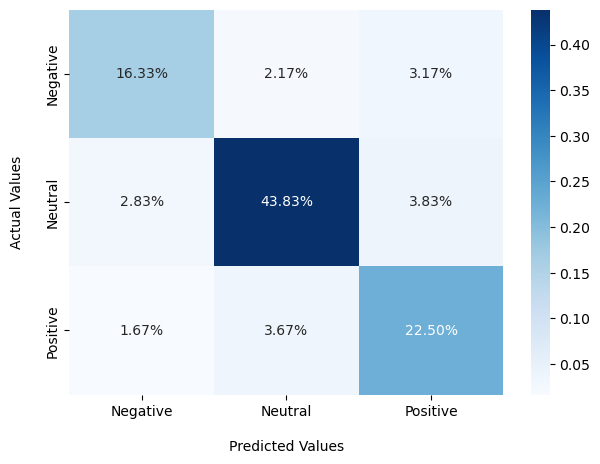

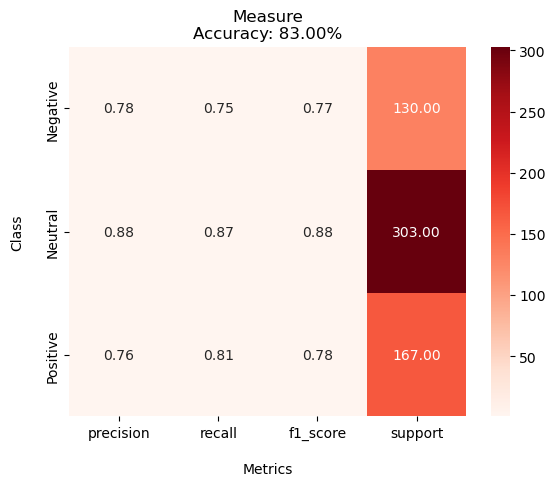

In [20]:
# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)

labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))


from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

print()
print()
print()

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()


## 3 Hidden Layers

In [21]:
#'''
tf.keras.backend.clear_session()
### MODEL 2 ####
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():

model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
#embeddings = embeddings[:, 0, :]

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)


bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate= 4e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)

#'''

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 103s 594ms/step - loss: 0.7766 - categorical_accuracy: 0.6756 - val_loss: 0.5500 - val_categorical_accuracy: 0.7903
Epoch 2/50
105/105 [==============================] - 58s 555ms/step - loss: 0.4962 - categorical_accuracy: 0.8232 - val_loss: 0.3339 - val_categorical_accuracy: 0.8847
Epoch 3/50
105/105 [==============================] - 58s 555ms/step - loss: 0.3520 - categorical_accuracy: 0.8887 - val_loss: 0.1937 - val_categorical_accuracy: 0.9403
Epoch 4/50
105/105 [==============================] - 58s 556ms/step - loss: 0.2344 - categorical_accuracy: 0.9351 - val_loss: 0.1415 - val_categorical_accuracy: 0.9569
Epoch 5/50
105/105 [==============================] - 58s 555ms/step - loss: 0.1959 - categorical_accuracy: 0.9369 - val_loss: 0.0908 - val_categorical_accuracy: 0.9778
Epoch 6/50
105/105 [==============================] - 58s 555ms/step - loss: 0.1526 - categorical_accuracy: 0.9554 - val_loss: 0.0719 - val_categorical_ac

              precision    recall  f1-score   support

    Negative       0.88      0.75      0.81       130
     Neutral       0.89      0.90      0.90       303
    Positive       0.78      0.85      0.82       167

    accuracy                           0.85       600
   macro avg       0.85      0.83      0.84       600
weighted avg       0.86      0.85      0.85       600






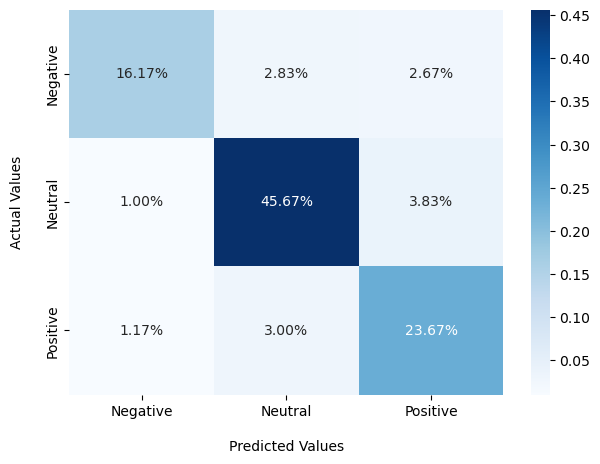

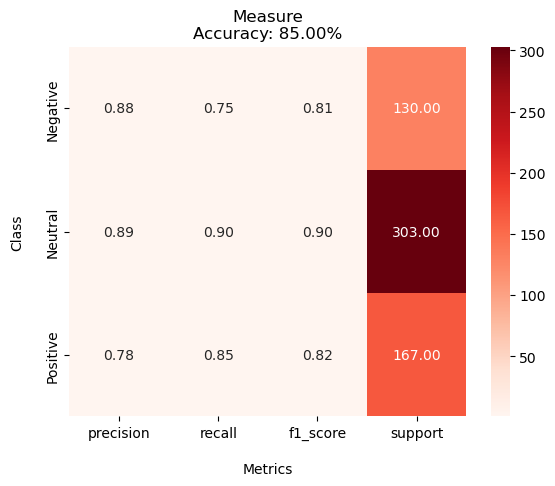

In [22]:
# For Data Visualization

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)

labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

print()
print()
print()

from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

print()
print()
print()

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()


## BiLSTM

In [23]:
#'''
####### MODEL 3 #########
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add a BiLSTM layer
lstm_units = 512 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)

# Add Dense layers
#x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Flatten the output tensor
x = tf.keras.layers.Flatten()(x)

# Classifier head
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

# Create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())

filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop]
    #callbacks=[lr_callback] 
)

#'''

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 108s 609ms/step - loss: 0.8212 - categorical_accuracy: 0.6601 - val_loss: 0.7035 - val_categorical_accuracy: 0.7319
Epoch 2/50
105/105 [==============================] - 59s 562ms/step - loss: 0.5671 - categorical_accuracy: 0.8030 - val_loss: 0.3485 - val_categorical_accuracy: 0.8889
Epoch 3/50
105/105 [==============================] - 59s 560ms/step - loss: 0.3971 - categorical_accuracy: 0.8708 - val_loss: 0.3213 - val_categorical_accuracy: 0.9014
Epoch 4/50
105/105 [==============================] - 59s 562ms/step - loss: 0.2935 - categorical_accuracy: 0.9077 - val_loss: 0.2506 - val_categorical_accuracy: 0.9167
Epoch 5/50
105/105 [==============================] - 59s 560ms/step - loss: 0.2436 - categorical_accuracy: 0.9321 - val_loss: 0.2066 - val_categorical_accuracy: 0.9375
Epoch 6/50
105/105 [==============================] - 59s 561ms/step - loss: 0.1935 - categorical_accuracy: 0.9429 - val_loss: 0.0867 - val_categorical_ac

              precision    recall  f1-score   support

    Negative       0.87      0.80      0.83       130
     Neutral       0.90      0.91      0.91       303
    Positive       0.82      0.87      0.85       167

    accuracy                           0.87       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.87      0.87      0.87       600






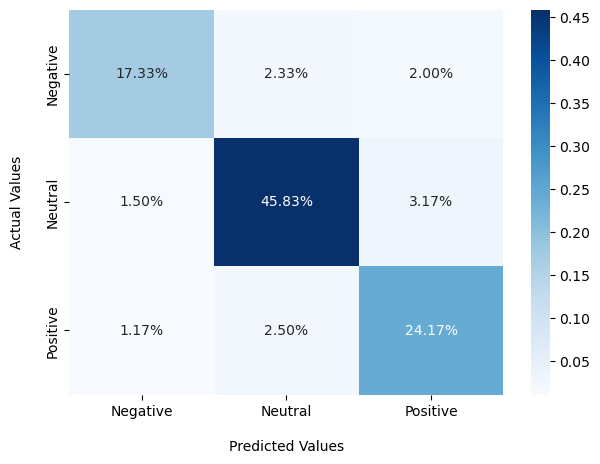

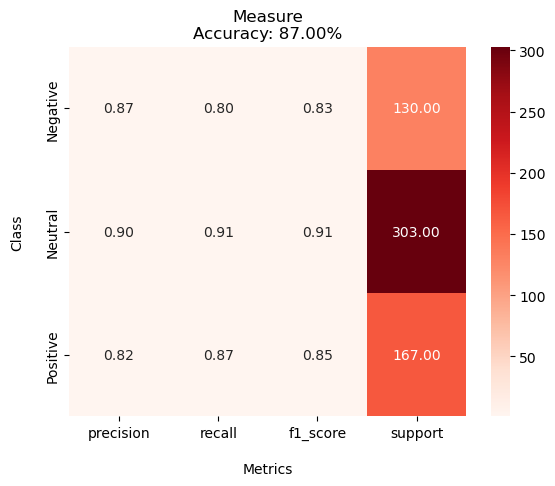

In [24]:
# For Data Visualization
bert_model = model

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)

labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

print()
print()
print()

from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

print()
print()
print()

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()


## BiLSTM+CNN

In [25]:
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add BiLSTM layer 1
lstm_units_1 = 512
bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_units_1, return_sequences=True))(embeddings)
bilstm_1 = tf.keras.layers.Dropout(rate=0.2)(bilstm_1)

# Add convolution layers
num_filters = 64
filter_sizes = [5, 5, 3]
conv_activation = 'relu'
dropout_rate = 0.2

conv1 = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=filter_sizes[0], activation=conv_activation, padding='same')(bilstm_1)
conv1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv1)

conv2 = tf.keras.layers.Conv1D(filters=num_filters*2, kernel_size=filter_sizes[1], activation=conv_activation, padding='same')(conv1)
conv2 = tf.keras.layers.Dropout(rate=dropout_rate)(conv2)

conv3 = tf.keras.layers.Conv1D(filters=num_filters*4, kernel_size=filter_sizes[2], activation=conv_activation, padding='same')(conv2)
conv3 = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(conv3)
conv3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv3)

# Add dense layers
hidden_units = [128, 64]
dense_activation = 'relu'

flatten = tf.keras.layers.Flatten()(conv3)
dense1 = tf.keras.layers.Dense(units=hidden_units[0], activation=dense_activation)(flatten)
dense1 = tf.keras.layers.Dropout(rate=dropout_rate)(dense1)

dense2 = tf.keras.layers.Dense(units=hidden_units[1], activation=dense_activation)(dense1)
dense2 = tf.keras.layers.Dropout(rate=dropout_rate)(dense2)

# Add Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(dense2)

# Define model
model = tf.keras.models.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop]
    #callbacks=[lr_callback] #
)


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 111s 608ms/step - loss: 1.0749 - categorical_accuracy: 0.4768 - val_loss: 1.0339 - val_categorical_accuracy: 0.5083
Epoch 2/50
105/105 [==============================] - 59s 562ms/step - loss: 1.0450 - categorical_accuracy: 0.5006 - val_loss: 1.0291 - val_categorical_accuracy: 0.5153
Epoch 3/50
105/105 [==============================] - 59s 558ms/step - loss: 1.0497 - categorical_accuracy: 0.4940 - val_loss: 1.0427 - val_categorical_accuracy: 0.4875
Epoch 4/50
105/105 [==============================] - 59s 558ms/step - loss: 1.0446 - categorical_accuracy: 0.4988 - val_loss: 1.0298 - val_categorical_accuracy: 0.5111
Epoch 5/50
105/105 [==============================] - 59s 558ms/step - loss: 1.0455 - categorical_accuracy: 0.4994 - val_loss: 1.0372 - val_categorical_accuracy: 0.5014
Epoch 6/50
105/105 [==============================] - 59s 558ms/step - loss: 1.0403 - categorical_accuracy: 0.5060 - val_loss: 1.0315 - val_categorical_ac

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       130
     Neutral       0.51      1.00      0.67       303
    Positive       0.00      0.00      0.00       167

    accuracy                           0.51       600
   macro avg       0.17      0.33      0.22       600
weighted avg       0.26      0.51      0.34       600






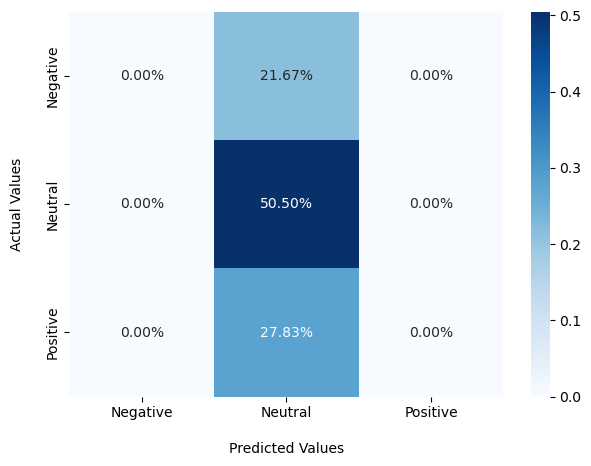

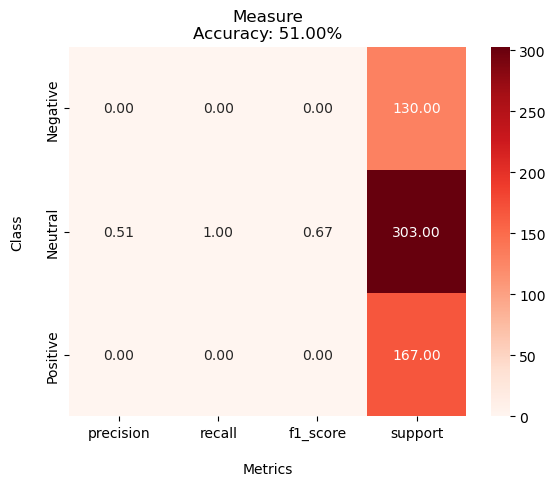

In [26]:
# For Data Visualization
bert_model = model

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)

labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

print()
print()
print()

from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

print()
print()
print()

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()

In [27]:
'''
model.load_weights('/kaggle/working/model.h5')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 5,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)
'''

"\nmodel.load_weights('/kaggle/working/model.h5')\nmodel.compile(optimizer=optimizer, loss=loss, metrics=[acc])\n\nhistory = model.fit(\n    train_ds,\n    validation_data=val_ds,\n    epochs= 5,\n    batch_size=batch_size,\n    callbacks=[early_stop, callbacks_list]\n    #callbacks=[lr_callback] #\n)\n"

In [28]:
#!zip -r file.zip /content/model.h5